# Efficient Inference on Single GPU

Reference: [1](https://huggingface.co/docs/transformers/perf_infer_gpu_one),[2](https://arxiv.org/abs/2208.07339)

Language models are becoming larger all the time. For example, [BLOOM-176B](https://huggingface.co/docs/transformers/model_doc/bloom). These models are hard to run on easily accessible devices. For example, just to do inference on BLOOM-176B, one would need 8x 80GB A100 GPUs (~$15k each). To finetune BLOOM-176B, one would need 72 of these GPUs. Much larger models than BLOOM requires even more resources. 

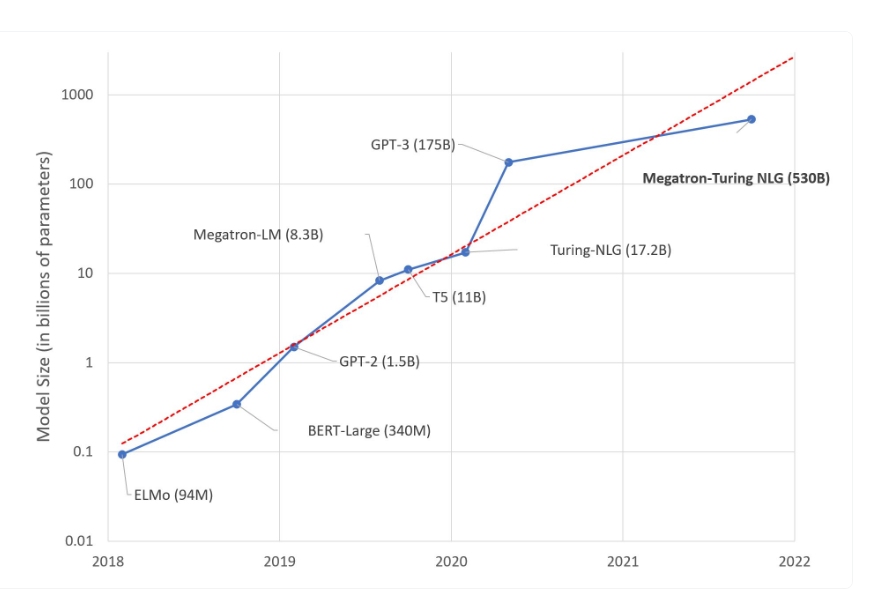

In [1]:
from IPython.display import Image
Image('../reports/figures/LLM_size.png')

[Source](https://www.tasq.ai/blog/large-language-models/)

Because these huge models require so many GPus to run, we need to find ways to reduce these requirements while preserving the model's performance. Various techniques, like quantization and distillation, have been developed that try to shrink the model size. 

## Data Types in Machine Learning

The size of the model is determined by the number of its parameters, and their precision, typically one of float32, float16 or bfloat16. 

**Float32** : It stands for the standardized IEEE 32 bit floating point representation. With this data type it is possible to represent a wide range of floating numbers. in FP32, 8 bits are reserved for the "exponent", 23 bits for "mantissa", and 1 bit for the sign of the number. In addition to that, most of the hardware supports FP32 operations and instructions. 

**Float16** : In this case, 5 bits are reserved for the "exponent" and 10 bits are reserved for the "mantissa". This makes the representable range of FB16 numbers, much lower then FB32. This exposes FP16 numbers to the risk of overflowing (trying to represent a number that is very large) and underflowing (representing a number that is very small). 

**BFLOAT16** : In order to overcome the risk of overflowing and underflowing, bfloat16 was created. Here, 8 bits are reserved for the "exponent" (same as float32) and 7 bits reserved for fraction. Hence, BF16 can retain the same dynamic range of FP32. But we lose 3 bits of precision with respect to FB32. Although there is no problem with huge numbers, the precision is worse than FP16. 

In Machine learning, FP32 is called full precision (4 bytes), while BF16 and FB16 are referred to as half precision (2 bytes). In addition, INT8 data type consists of an 8-bit representation that can store 2^8 different values. 

To calculate the model size in bytes, one multiplies the number of parameters by the size of the chosen precision in bytes. For example, if we use float16 version of bloom-176b model, we have (176*10^9)*2 bytes ~ 352 GB, which is quite challenging to fit into a few GPUs.  

## Model Quantization

Ideally the training and inference should be done in FP32, it is two times slower than FP16/BF16 and therefore a mixed precision approach is used where the weights are held in FP32 as a precise "main weights" reference, while computation in a forward and backward pass are done for FP16/BF16 to enhance training speed. The FP16/BF16 gradients are then used to update the FP32 main weights.

During training, the main weights are always stored in FP32, but in practice, the half-precision weights often provide similar quality during inference as their FP32 counterpart, i.e, we can get almost identical outcome with 2-byte BF16/FB16 half precesion, which halves the model size. If we reduce it further, the inference quality outcome starts to drop at lower precision. In order to overcome this, **8bit-quantization** is introduced. 

The two most common 8-bit quantization techniques are zero-point quantization and absolute maximum (absmax) quantization. Zero-point quantization and absolute maximum quantization map the floating point values into more compact int8 (1 byte) values. These methods normalize the input by scaling it by a quantization constant. 

For example, in zero-point quantization, if my range is -1.0…1.0 and I want to quantize into the range -127…127, I want to scale by the factor of 127 and then round it into the 8-bit precision. To retrieve the original value, you would need to divide the int8 value by that same quantization factor of 127. For example, the value 0.3 would be scaled to 0.3*127 = 38.1. Through rounding, we get the value of 38. If we reverse this, we get 38/127=0.2992 – we have a quantization error of 0.008 in this example. These seemingly tiny errors tend to accumulate and grow as they get propagated through the model’s layers and result in performance degradation.

Now let's look at the details of absmax quantization. To calculate the mapping between the fp16 number and its corresponding int8 number in absmax quantization, you have to first divide by the absolute maximum value of the tensor and then multiply by the total range of the data type.

For example, let's assume you want to apply absmax quantization in a vector that contains [1.2, -0.5, -4.3, 1.2, -3.1, 0.8, 2.4, 5.4]. You extract the absolute maximum of it, which is 5.4 in this case. Int8 has a range of [-127, 127], so we divide 127 by 5.4 and obtain 23.5 for the scaling factor. Therefore multiplying the original vector by it gives the quantized vector [28, -12, -101, 28, -73, 19, 56, 127]. To retrieve the latest, one can just divide in full precision the int8 number with the quantization factor, but since the result above is "rounded" some precision will be lost.

These tricks can be combined in several ways, row wise or vector wise quantization, when it comes to matrix multiplication for more accurate results. 
More details can be found in this [LLM.int8()](https://arxiv.org/abs/2208.07339) paper. 

These basic techniques enable us to quantize Deep Learning models, then usually lead to drop in accuracy for larger models. The LLM.int8() implementation that was integrated with hugging face transformers and accelerate libraries is the first technique that does not degrade the performance even for large models, liek BLOOM-176B. 

### [LLM.Int8](https://arxiv.org/abs/2208.07339)

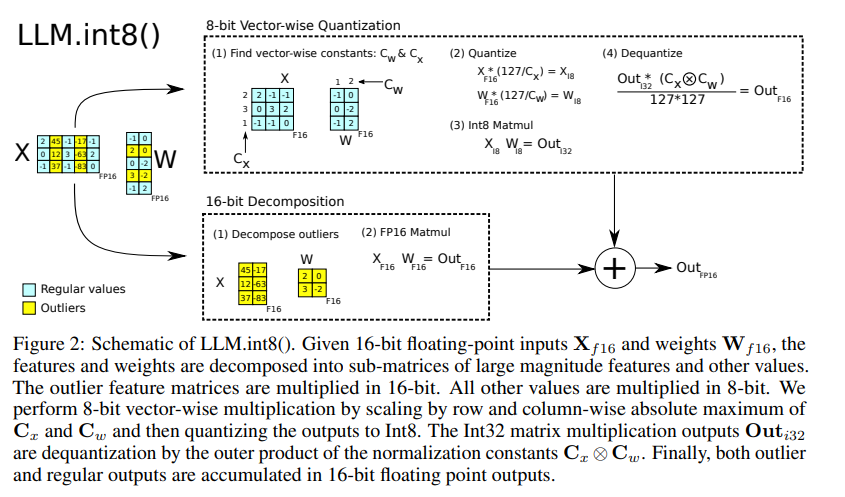

In [2]:
Image(filename='../reports/figures/llm_int8.png')

In essence, LLM.int8() seeks to complete the matrix multiplication computation in three steps:

1. From the input hidden states, extract the outliers (i.e. values that are larger than a certain threshold) by column.
2. Perform the matrix multiplication of the outliers in FP16 and the non-outliers in int8.
3. Dequantize the non-outlier results and add both outlier and non-outlier results together to receive the full result in FP16.

## Demo

In the next case, we will check the gpu memory foot print and gpu utilization information when we quantize bloom-3b. 

In [4]:
from torch import cuda
import scipy
import torch
import time
import warnings
import GPUtil
from IPython.display import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
warnings.filterwarnings('ignore')

### Hardware Requirements

- If you have bitsandbytes<0.37.0, make sure you run on NVIDIA GPUs that support 8-bit tensor cores (Turing, Ampere or newer architectures - e.g. T4, RTX20s RTX30s, A40-A100). 
- For bitsandbytes>=0.37.0, all GPUs should be supported.
- Install the correct version of bitsandbytes by running: pip install bitsandbytes>=0.31.5
- Install accelerate pip install accelerate>=0.12.0

In [5]:
# View GPU utilization when nothing is running on it
device = -1  # cpu
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = 0  # first GPU
# Get all available GPUs
gpus = GPUtil.getGPUs()
GPUtil.showUtilization(all=True)

| ID | Name     | Serial        | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | Tesla T4 | 1564620006411 | GPU-e8a8cf27-187d-2821-36c5-e654c154fbb1 ||       33C |        0% |           0% ||      15360MB |         5MB |     14923MB || Enabled      | Disabled       |


we are using Tesla T4 GPU that should support 8-bit tensor cores. We see that memory 5MB is used after loading kernals. In next case, we will try to load models and check the memory utilization.

### Model and Helper function

In [6]:
model_name = "bigscience/bloom-3b"
text = "I am running bloom 3b"
max_new_token = 20

In [7]:
def generate_from_model(model, tokenizer):
  encoded_input = tokenizer(text, return_tensors='pt')
  output_sequences = model.generate(input_ids=encoded_input['input_ids'].cuda())
  return tokenizer.decode(output_sequences[0], skip_special_tokens=True)

### Loading Model without 8-bit quantization

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_org = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

# Number of times to run the inference
num_iterations = 10
total_inference_time = 0

# Run inference multiple times
for _ in range(num_iterations):
    start_time = time.time()
    # Replace generate_from_model with your actual inference function
    generate_from_model(model_org, tokenizer)
    end_time = time.time()

    inference_time = (end_time - start_time) * 1000
    total_inference_time += inference_time

# Calculate and print the mean inference time
mean_inference_time = total_inference_time / num_iterations
print(f"Mean Inference time: {mean_inference_time} ms")

Some weights of BloomForCausalLM were not initialized from the model checkpoint at bigscience/bloom-3b and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean Inference time: 453.4655570983887 ms


In [11]:
GPUtil.showUtilization(all=True) 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | Name     | Serial        | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | Tesla T4 | 1564620006411 | GPU-e8a8cf27-187d-2821-36c5-e654c154fbb1 ||       40C |       98% |          42% ||      15360MB |      6519MB |      8409MB || Enabled      | Disabled       |


We see that **memory used is 6519MB** when we load the model without 8-bit quantization. The **inference time is ~453 ms**.

### Loading Model with 8-bit quantization

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_8bit = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_8bit=True, torch_dtype=torch.float16)

# Number of times to run the inference
num_iterations = 10
total_inference_time = 0

# Run inference multiple times
for _ in range(num_iterations):
    start_time = time.time()
    # Replace generate_from_model with your actual inference function
    generate_from_model(model_8bit, tokenizer)
    end_time = time.time()

    inference_time = (end_time - start_time) * 1000
    total_inference_time += inference_time

# Calculate and print the mean inference time
mean_inference_time = total_inference_time / num_iterations
print(f"Mean Inference time: {mean_inference_time} ms")

Some weights of BloomForCausalLM were not initialized from the model checkpoint at bigscience/bloom-3b and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean Inference time: 1659.8277807235718 ms


In [9]:
GPUtil.showUtilization(all=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | Name     | Serial        | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | Tesla T4 | 1564620006411 | GPU-e8a8cf27-187d-2821-36c5-e654c154fbb1 ||       36C |       38% |          28% ||      15360MB |      4323MB |     10605MB || Enabled      | Disabled       |


We see that **memory used is 4323MB** when we load the model with 8-bit quantization. The **mean inference time in this case is ~1659 ms**.

## Conclusion

**Without 8-bit quantization**

- Memory Used: 6519 MB
- Inference Time : 453 ms

**With 8-bit quantization**

- Memory Used: 4323 MB
- Inference Time : 1659 ms

After applying 8-bit quantization to the model, there is a decrease of approximately **33.60%** in memory usage compared to the non-quantized version. However, this reduction in memory usage comes at the cost of an approximately **266.85%** increase in mean inference time. Therefore, while 8-bit quantization helps save memory, it also leads to a significant increase in inference time, indicating a trade-off between memory efficiency and computational speed. The choice between the two depends on the specific requirements and priorities of the application.